INTRODUCTION

In today's interconnected world, social media influences not only our personal lives but also the daily operations of businesses. For companies, understanding public sentiment about their products and brands is essential for adapting to shifting trends quickly—or even staying ahead of them. By staying informed, businesses can maintain relevance and seize opportunities for financial success.

A clear example of this is when major companies like Apple and Google host keynotes, such as Apple's WWDC or Google's I/O, where they unveil new products and software updates while teasing future changes. These events, along with senior leadership appearances at conferences where they share the company's vision, provide valuable opportunities for marketing teams to gauge interest and gather insights on public opinion.

Twitter serves as a powerful platform for assessing public sentiment, with millions of users sharing their thoughts daily. For this project, we were commissioned by Apple to conduct a sentiment analysis of tweets from the SXSW (South by Southwest) Conference. The key questions we aim to address are:

How is Apple perceived as a company during the SXSW Conference, and how does this perception compare to that of Google, its main competitor?

How are the products and announcements from Apple and Google received at the SXSW Conference? Are there specific pain points in Apple’s products that need to be addressed?

Furthermore, we will be training and testing various machine learning models to classify tweets based on sentiment. Apple can utilize these models to better understand public opinion and stay ahead of the competition.

In [396]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
import string
import re
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB


from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_colwidth', 10000)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Annolyne.Chemutai\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package omw-1.4 is already up-to-date!


**Loading the Data**

We will utilize a dataset from data.world, provided by CrowdFlower, containing tweets about Apple and Google from the South by Southwest (SXSW) conference. The labels for these tweets were crowdsourced, indicating the emotions they convey and the specific product, service, or company to which these emotions are directed based on the content.

In [397]:
# Loading the Data from the source i.e. csv

df = pd.read_csv(r'..\\data\\judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [398]:
# Previewing the bottom of our dataset
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link},NaN,No emotion toward brand or product


**Data Cleaning**

The column names are overly long and challenging to read. We can simplify and rename them to enhance both readability and interpretability.

In [399]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product/Brand', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head()

,Tweet,Product/Brand,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


Next, let's examine the unique values in the Product/Brand and Sentiment columns to understand what data we are working with.

In [400]:
df['Sentiment'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [401]:
df['Product/Brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

The dataset provides comprehensive information on a range of services and products for each company, as well as instances of null values and an "I can't tell" emotion. We will address these issues in the subsequent analysis.

**Addressing Missing and Placeholder Values**


In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Duplicates and Null values


In [403]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))

# Check for duplicated rows
print('Total duplicated rows')
print(df.duplicated().sum())
print(("-"*20))

# Check for null values
print('Total null values')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
Total duplicated rows
22
--------------------
Total null values
Tweet               1
Product/Brand    5802
Sentiment           0
dtype: int64


The DataFrame contains 22 duplicate rows. This means there are 22 entries that are identical across all columns. Whereas the Product/Brand has 5801 a significant number of missing values.

Cleaning the Tweet Column 



In [404]:
df = df[df['Tweet'].isna() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Sentiment      9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [405]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product/Brand,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


Checking the contents in the product and sentiment columns



In [406]:
df[df['Product/Brand'].isna()].head()
print(df)

                                                                                                                                                  Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                   

In [407]:
df['Product/Brand'].fillna('Unknown', inplace=True)
print(df)

                                                                                                                                                  Tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                   

In [408]:
# Print the value count of product and sentiment column
print(df['Product/Brand'].value_counts())
print(("-"*20))
print(df['Sentiment'].value_counts())

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: Product/Brand, dtype: int64
--------------------
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Sentiment, dtype: int64


Similar to the initial column names, the values in the emotion column can be cleaned up a bit for easy interpretability and to shorten the amount of typing for the code.

In [409]:
Sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['Sentiment'] = df['Sentiment'].map(Sentiment_dict)
df.head()

,Tweet,Product/Brand,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive


In [410]:
df['Sentiment'].value_counts()


Neutral     5388
Positive    2978
Negative     570
Unknown      156
Name: Sentiment, dtype: int64

Now we can take a look at the tweets with "Unknown" emotion values to see if we can notice any patterns or tell easily whether the tweet has a negative, neutral or positive emotion.



In [411]:
pd.set_option("display.max_colwidth", 300)
df[df['Sentiment']=='Unknown']

,Tweet,Product/Brand,Sentiment
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,Unknown,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,Unknown,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,Unknown,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},Unknown,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,Unknown,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",Unknown,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",Unknown,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,Unknown,Unknown


In [412]:
df = df[df['Sentiment']!='Unknown']
df['Sentiment'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: Sentiment, dtype: int64

Checking for and Addressing Duplicates

Now that we've addressed null values, and cleaned up our dataset a little bit more, next step is to check for duplicates to see if we have the same tweets represented multiple times.



In [413]:
len(df[df.duplicated()])


22

    We have 22 tweets that are duplicated in the dataset. Let's take a look at the duplicates for reference.



In [414]:
df[df.duplicated()]


,Tweet,Product/Brand,Sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Neutral
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,Unknown,Neutral
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,Unknown,Neutral
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",Unknown,Neutral
5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Neutral


In [415]:
#Drop the duplicats
df.drop_duplicates(keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          8914 non-null   object
 1   Product/Brand  8914 non-null   object
 2   Sentiment      8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


In [416]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Product/Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Product/Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment  Product/Brand                  
Negative   iPad                               0.219684
           iPhone                             0.179262
           Apple                              0.166960
           Google                             0.119508
           iPad or iPhone App                 0.110721
           Unknown                            0.089631
           Other Google product or service    0.082601
           Android                            0.014060
           Android App                        0.014060
           Other Apple product or service     0.003515
Neutral    Unknown                            0.983070
           iPad                               0.004465
           Apple                              0.003907
           Google                             0.002791
           iPad or iPhone App                 0.001860
           Other Google product or service    0.001674
           iPhone                             0.001674
           Android    

------------------------------------------------------------


Product/Brand                    Sentiment
Android                          Positive     0.883117
                                 Negative     0.103896
                                 Neutral      0.012987
Android App                      Positive     0.887500
                                 Negative     0.100000
                                 Neutral      0.012500
Apple                            Positive     0.823440
                                 Negative     0.144597
                                 Neutral      0.031963
Google                           Positive     0.805621
                                 Negative     0.159251
                                 Neutral      0.035129
Other Apple product or service   Positive     0.914286
                                 Negative     0.057143
                                 Neutral      0.028571
Other Google product or service  Positive     0.808219
                                 Negative     0.160959
                      

In [417]:
#Number of Tweets per product
print(df["Product/Brand"].value_counts())
print("-"*60)
#Number of Tweets per Sentiment
print(df["Sentiment"].value_counts())
print("-"*60)
#Number of Tweet per Brand
print(df["Product/Brand"].value_counts())
print("-"*60)

Unknown                            5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product/Brand, dtype: int64
------------------------------------------------------------
Neutral     5375
Positive    2970
Negative     569
Name: Sentiment, dtype: int64
------------------------------------------------------------
Unknown                            5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Oth

In [418]:
#Final DataFrame before Preprocessing
df

,Tweet,Product/Brand,Sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",Unknown,Neutral
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",Unknown,Neutral
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Unknown,Neutral


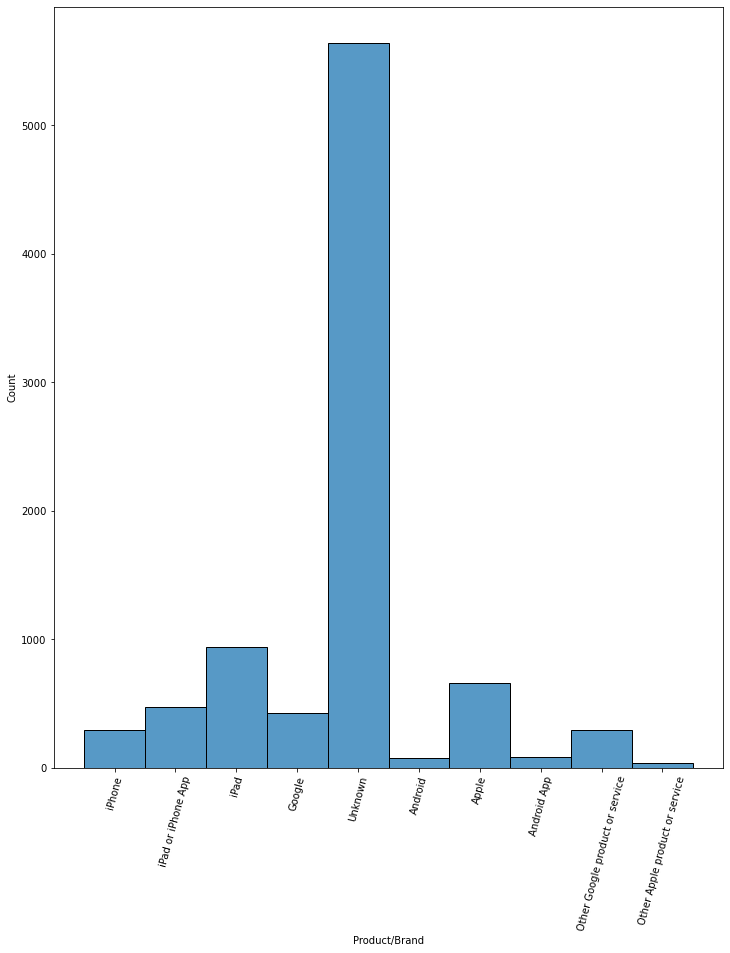

In [419]:
#Plot to check the distribution
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product/Brand"] )
plt.xticks(rotation = 75)
plt.show()

EXPLORATORY DATA ANALYSIS


With the business problem in mind, it is important to isolate and analyze positive and negative tweets as a whole as well as on a company and product basis. We will start our exploration with positive tweets.



Tweets with Positive Sentiment

Lets explore the data where we have positive sentiments . 

In [420]:
#parsing positive tweets into new df
df_positive = df[df['Sentiment']=='Positive']
#verifying that neutral and negative tweets have been removed
df_positive['Sentiment'].value_counts()

Positive    2970
Name: Sentiment, dtype: int64

In [421]:
#parsing tweets into a list
corpus_pos = df_positive['Tweet'].to_list()
corpus_pos[:5]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

Tokenization

For tokenizing the tweets we will be using the TweetTokenizer throughout this project since it has built-in functionality such as processing handles and hashtags correctly unlike other tokenizers. We will drop any handles from the tweets since we are mainly focused on the content of the tweet.

In [422]:
from nltk import TweetTokenizer
import string

def tokenize_tweets(corpus, preserve_case=False, strip_handles=True):
    """
    Tokenizes a collection of tweets into individual tokens.

    Parameters:
    - corpus: A collection of tweets in a format suitable for tokenization.
    - preserve_case: If True, preserves uppercase letters; otherwise, converts to lowercase.
    - strip_handles: If True, removes Twitter handles from the tokens.

    Returns:
    - A list of tokens extracted from the tweets.
    """
    # Initialize the TweetTokenizer with the specified options
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    
    # Join the corpus into a single string and tokenize it
    tokens = tokenizer.tokenize(' '.join(corpus))
    return tokens


In [423]:
#tokenize positive tweets
tokens_pos = tokenize_tweets(corpus_pos)

In [424]:
#displaying 10 most common tokens
from nltk import FreqDist
freq = FreqDist(tokens_pos)
freq.most_common(10)

[('#sxsw', 2984),
 ('.', 2227),
 ('the', 1590),
 ('!', 1241),
 ('link', 1214),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 (',', 1096),
 ('at', 1019)]

We can see that our tokens contain a lot of punctuation and stop words like "to" and "at" since we haven't removed these yet. Prior to removing these though, we will be lemmatizing the tokens to make sure we're capturing any stop words that may be generated with this process.

Lemmatization


In [425]:
from nltk.stem import WordNetLemmatizer
from typing import List

def lemmatize_tokens(tokens_list: List[str]) -> List[str]:
    """
    Lemmatizes a list of tokens using WordNetLemmatizer.

    Parameters:
    - tokens_list: A list of tokens to be lemmatized.

    Returns:
    - A list of lemmatized tokens.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each token in the list
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm


In [426]:
#lemmatizing positive tweet tokens
tokens_pos_lemm = lemmatize_tokens(tokens_pos)

In [427]:
#displaying most common 10 tokens
from nltk import FreqDist
freq = FreqDist(tokens_pos_lemm)
freq.most_common(10)

[('#sxsw', 2984),
 ('.', 2227),
 ('the', 1590),
 ('!', 1241),
 ('link', 1218),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 (',', 1096),
 ('at', 1019)]

Punctuation and stop words remain in our list. After lemmatizing tokens, we'll remove these elements as they don't significantly impact tweet sentiment. This removal will highlight more relevant information and enhance model performance.

Stop Word/Punctuation Removal


In [428]:
import string
from nltk.corpus import stopwords

# Retrieve the English stopwords from NLTK
stop_lst = stopwords.words('english')

# Add punctuation characters to the stop words list
stop_lst.extend(list(string.punctuation))

# Add additional characters and empty string to the stop words
additional_punctuation = ['“', '”', '...', "''", '’', '``', '']
stop_lst.extend(additional_punctuation)


In [429]:
from typing import List

def remove_stop(tokens: List[str], stop_list: List[str] = stop_lst) -> List[str]:
    """
    Removes stop words from a list of tokens.

    Parameters:
    - tokens: A list of tokens from which to remove stop words.
    - stop_list: A list of stop words to be removed (default is the predefined stop_lst).

    Returns:
    - A list of tokens with stop words removed.
    """
    # Remove unrecognized symbols and external links
    tokens_stopped = [
        word.encode('ascii', 'ignore').decode() 
        for word in tokens 
        if word not in stop_list and not word.startswith('http')
    ]
    
    return tokens_stopped


In [430]:
# Remove stop words from the lemmatized tokens
tokens_pos_ls = remove_stop(tokens_pos_lemm)


In [431]:
#displaying most common 50 tokens
freq = FreqDist(tokens_pos_ls)
freq.most_common(50)

[('#sxsw', 2984),
 ('link', 1218),
 ('ipad', 1010),
 ('rt', 935),
 ('apple', 711),
 ('google', 603),
 ('2', 595),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 359),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('sxsw', 144),
 ('line', 143),
 ('great', 136),
 ('time', 136),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('free', 120),
 ('cool', 119),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('win', 112),
 ('today', 111),
 ('ha', 108),
 ('circle', 107),
 ('w', 104),
 ('go', 104),
 ('come', 103),
 ('wa', 100),
 ('#sxswi', 96),
 ('awesome', 93),
 ('#ipad', 93),
 ('love', 93),
 ('good', 92),
 ('network', 91),
 ('mobile', 90),
 ('temporary', 89),
 ('downtown', 88)]

Our updated list of the 50 most common words still contains some that don't provide useful information about tweet sentiment. Since we know these tweets are from the SXSW Conference, we can remove hashtags like "#sxsw" by adding them to our stop words list. Words such as "link" and "rt" likely refer to external links and retweets, respectively. However, "link" might also be used in its dictionary sense. To understand how a word appears in our corpus, we can create a function that:

1. Takes a random sample of tweets from the corpus
2. Checks if our target word appears in any of these tweets
3. Displays the tweets containing the word

This approach will help us better understand the context and usage of specific words in our dataset.

In [432]:
#adding sxsw to stop list
stop_lst += ['#sxsw', '#sxswi', 'sxsw']

In [433]:
import numpy as np
from typing import List

def context_finder(word: str, corpus: List[str], n_samples: int = 5, n_count: int = 5) -> None:
    """
    Provides context for a specified word by sampling tweets from a given corpus.

    Parameters:
    - word: The word for which context is being sought.
    - corpus: A list of tweets (the document containing the word).
    - n_samples: The number of samples to collect from the corpus.
    - n_count: The number of tweets in each sample.

    Returns:
    - None
    """
    
    total_tweets_analyzed = 0
    matching_tweets_count = 0
    
    for _ in range(n_samples):
        sample = np.random.choice(corpus, n_count)
        for tweet in sample:
            if word in tweet:
                print(tweet)
                matching_tweets_count += 1
                total_tweets_analyzed += 1

    print('-----------------------------------')
    print(f'Out of {total_tweets_analyzed} tweets analyzed, '
          f'{matching_tweets_count} tweets contained the word "{word}".')


In [434]:
# Verify that the word 'link' is used in reference to external web links
context_finder('link', corpus_pos)


RT @mention Hey #SXSW- ers RT @mention RT @mention Last day to get the #LP Austin iPhone app for free {link} #travel
Ming.ly is launching soon and celebrating by giving away an Apple TV each day! #sxsw #launch {link} via @mention
It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch: It'... {link}
Last month it was Discovr for iPad at #midem. This time it's Discovr for iPhone at #sxsw. Climbing the App Store charts! {link}
RT @mention Updated NPR Music iPhone app has song info for All Songs 24/7 &amp; live video streaming just in time for #SXSW {link}
Google to Launch Major New Social Network Called Circles, {link} #sxsw - Brazil's orkut users have been waiting.
RT @mention #SXSW #Hootsuite #Chilltab #Tablet Stand rocks! Canadian Social Media for #ipad at its best @mention {link}
Another super smart move by apple  {link} Temporary store at SXSW #apple #sxsw
Great visualisation of the ghost movement logic in PacMan during the Google D

Analysis reveals that 'link' primarily refers to web links removed during dataset parsing. Since this doesn't offer meaningful insights into tweet content, we can confidently add 'link' to our stop words list.

In [435]:
stop_lst += ['link']


Now, we can take a look at 'RT' to confirm that it was used to refer to retweets.



In [436]:
context_finder('RT', corpus_pos)


RT @mention &quot;She's the iPad DJ working the Etsy party.&quot; #realtalk #sxsw
RT @mention #SXSW #sxswparty Matt Damon upstairs at the Google party Maggie Maes 6th st
RT @mention Check out the {link} site - download the iPhone app and get ready for SXSW (special Q&amp;A stream) #SXSW
brilliant. RT @mention Apple set to open popup shop in core of SXSW action  - they're going to sell iPad2 at #SXSW! {link}
RT @mention Hey foodies: if you're in Austin for SXSW download the new ARW iphone/android app and use it as a guide to dine while you're in town! #SXSW
-----------------------------------
Out of 5 tweets analyzed, 5 tweets contained the word "RT".


In all cases, "RT" (or "rt" after our tokenizer converted it to lowercase) was used to indicate a retweet. As a result, we can safely add it to our stop words list.

In [437]:
stop_lst += ['rt']


In [438]:
# Update the tokens list by removing stop words from the updated stop words list
tokens_pos_ls = remove_stop(tokens_pos_ls, stop_list=stop_lst)


50 Most Frequent Words in Positive Tweets
One way to get some valuable insights about the tweets is to take a look at the most frequently occuring words in the tweets.

In [439]:
from nltk import FreqDist
from typing import List, Tuple

def find_frequent(tokens: List[str], n: int = 50) -> None:
    """
    Returns the n most common tokens along with their frequencies.

    Parameters:
    - tokens: A list of tokens from which to find the most common words.
    - n: The number of top words to return (default is 50).

    Returns:
    - None
    """
    
    # Calculate frequency distribution of the tokens
    freq = FreqDist(tokens)
    
    # Display the n most common tokens and their frequencies
    most_common_tokens = freq.most_common(n)
    for token, count in most_common_tokens:
        print(f"{token}: {count}")


In [440]:
# Display the 50 most frequent words from the token list
find_frequent(tokens_pos_ls)


ipad: 1010
apple: 711
google: 603
2: 595
store: 554
iphone: 466
app: 387
new: 359
austin: 250
get: 181
#apple: 174
launch: 173
android: 161
party: 151
pop-up: 151
line: 143
great: 136
time: 136
via: 132
#ipad2: 129
day: 124
social: 122
free: 120
cool: 119
i'm: 115
like: 115
map: 115
one: 114
win: 112
today: 111
ha: 108
circle: 107
w: 104
go: 104
come: 103
wa: 100
awesome: 93
#ipad: 93
love: 93
good: 92
network: 91
mobile: 90
temporary: 89
downtown: 88
opening: 88
people: 82
open: 82
#iphone: 82
got: 81
apps: 78


As expected, 'apple' and 'google' are among the most common words. However, terms like 'circle', 'launch', and 'store' offer deeper insights into people's interests. While our analysis covers only 50 words, we might be missing additional valuable information. To gain a more comprehensive view, we can use word clouds to visualize the data.

WordCloud with Product/Company Information for Positive Tweets


In [441]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import List

def generate_wordcloud(
    tokens: List[str], 
    collocations: bool = False, 
    background_color: str = 'black', 
    colormap: str = 'Greens', 
    display: bool = True,
    font_path: str = None  # Optional parameter for font path
) -> WordCloud:
    """
    Generates a word cloud from a list of tokens.

    Parameters:
    - tokens: A list of tokens to generate the word cloud from.
    - collocations: Whether to include collocations (bigrams) of two words (default is False).
    - background_color: Background color of the resulting word cloud (default is 'black').
    - colormap: The color map for the words in the word cloud (default is 'Greens').
    - display: Whether to show the resulting word cloud (default is True).
    - font_path: Optional path to a font file to use for the word cloud.

    Returns:
    - A WordCloud object generated from the tokens.
    """
    
    if not tokens:
        raise ValueError("The tokens list is empty. Please provide valid tokens.")

    # Initialize a WordCloud with a specified font if provided
    wordcloud = WordCloud(
        collocations=collocations, 
        background_color=background_color, 
        colormap=colormap, 
        width=500, 
        height=300,
        font_path=font_path  # Use the specified font path
    )

    # Generate word cloud from tokens
    wordcloud.generate(' '.join(tokens))

    # Plot with matplotlib if display is True
    if display:
        plt.figure(figsize=(12, 15), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    return wordcloud

# Example token list
tokens_pos_ls = ['word1', 'word2', 'word1', 'word3', 'word4', 'word2']

# Generate and display the word cloud
cloud_pos_w_company = generate_wordcloud(tokens_pos_ls, collocations=True)


AttributeError: 'TransposedFont' object has no attribute 'getbbox'